```{include} ../math-definitions.md
```

# Una breve historia

In [1]:
from bccr import SW
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

## ¿Para qué estudiar series de tiempo?

El análisis de series de tiempo ayuda a detectar **regularidades** en las observaciones de una variable y derivar **leyes** a partir de ellas, o bien para explotar toda la información incluida en la variable para **predecir** mejor el futuro.

El análisis de series de tiempo ha tenido un papel importante en la ciencia desde la antigüedad.

- Por ejemplo, los astrónomos babilonios usaron series de tiempo de las posiciones relativas de las estrellas y planetas para predecir eventos astronómicos.
- Kepler descubrió las leyes que llevan su nombre a partir de observaciones de los movimientos de los planetas.

## Inicios 1900s ->  Evgenij E. Slutzky y George Udny Yule  

A inicios del siglo XX, Slutzky y Yule mostraron que series de tiempo con propiedades similares a series económicas pueden generarse como  sumas o restas (simples o ponderadas) de procesos puramente aleatorios.

Desarrollaron los procesos de media móvil y autorregresivos como modelos para representar series de tiempo.


## 1919 -> Warren M. Persons  
En 1919 Persons propuso la descomposición de una serie de tiempo en componentes no observables que dependen de causas distintas. Los componentes son:

* un movimiento de largo plazo, la **tendencia**,
* un componente cíclico con períodos de más de un año, el **ciclo económico**,
* un componente que contiene los aumentos y disminuciones dentro del año, el ciclo **estacional**,
* un componente que contiene todos los movimientos no atribuibles a los demás componentes, el residual o **componente irregular**.




```{panels}
:header: bg-dark text-center text-white

Aditiva
^^^
\begin{equation*}
Y_t = T_t + C_t + S_t + I_t
\end{equation*}
---

Multiplicativa
^^^
\begin{equation*}
Y_t = T_t \times C_t \times S_t \times I_t
\end{equation*}
```

<div class="ejemplo">
<div class="ejemplo-titulo">Ejemplo 1.1: Componentes del IMAE</div>
En el siguiente ejemplo vemos los componentes del IMAE de Costa Rica.

In [2]:
imaes = SW.buscar('IMAE serie original', frecuencia='M', Unidad='Nivel')
imaes[imaes.descripcion.str.contains('IMAE')]

,DESCRIPCION,descripcion,Unidad,Medida,periodo
codigo,,,,,
913,"Node('/BCCR/Sector Real/IMAE con IEAT, Serie Original [913]')",Indice Mensual de Actividad Económica (IMAE) con la Industria Electronica de Alta Tecnologia (IEAT). Serie Original,Nivel,NO DEFINIDO,Mensual
915,"Node('/BCCR/Sector Real/IMAE sin IEAT, Serie Original [915]')",Índice Mensual de Actividad Económica (IMAE) sin la Industria Electrónica de Alta Tecnología (IEAT). Serie Original,Nivel,NO DEFINIDO,Mensual
22967,Node('/BCCR/Sector Real/IMAE sin Zona Franca Serie Original [22967]'),IMAE sin Zona Franca Serie Original,Nivel,NO DEFINIDO,Mensual
22970,Node('/BCCR/Sector Real/IMAE sin Zona Franca Serie Tendencia Ciclo [22970]'),IMAE sin Zona Franca Serie Original,Nivel,NO DEFINIDO,Mensual
35449,"Node('/BCCR/Sector Real/IMAE , Serie Original [35449]')","IMAE , Serie Original",Nivel,NO DEFINIDO,Mensual


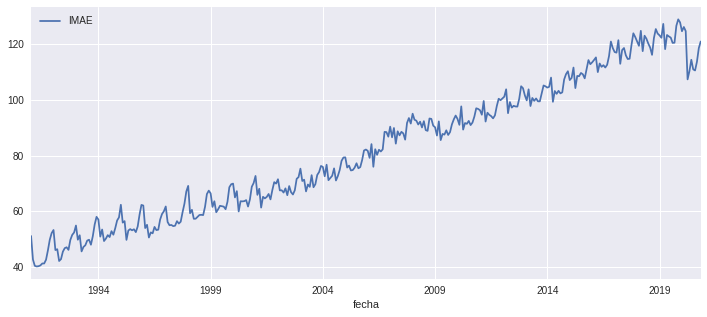

In [3]:
imae = SW(IMAE=35449)  # descargar el imae
imae.plot(figsize=[12,5]);

Descomposición aditiva y multiplicativa del IMAE de Costa Rica

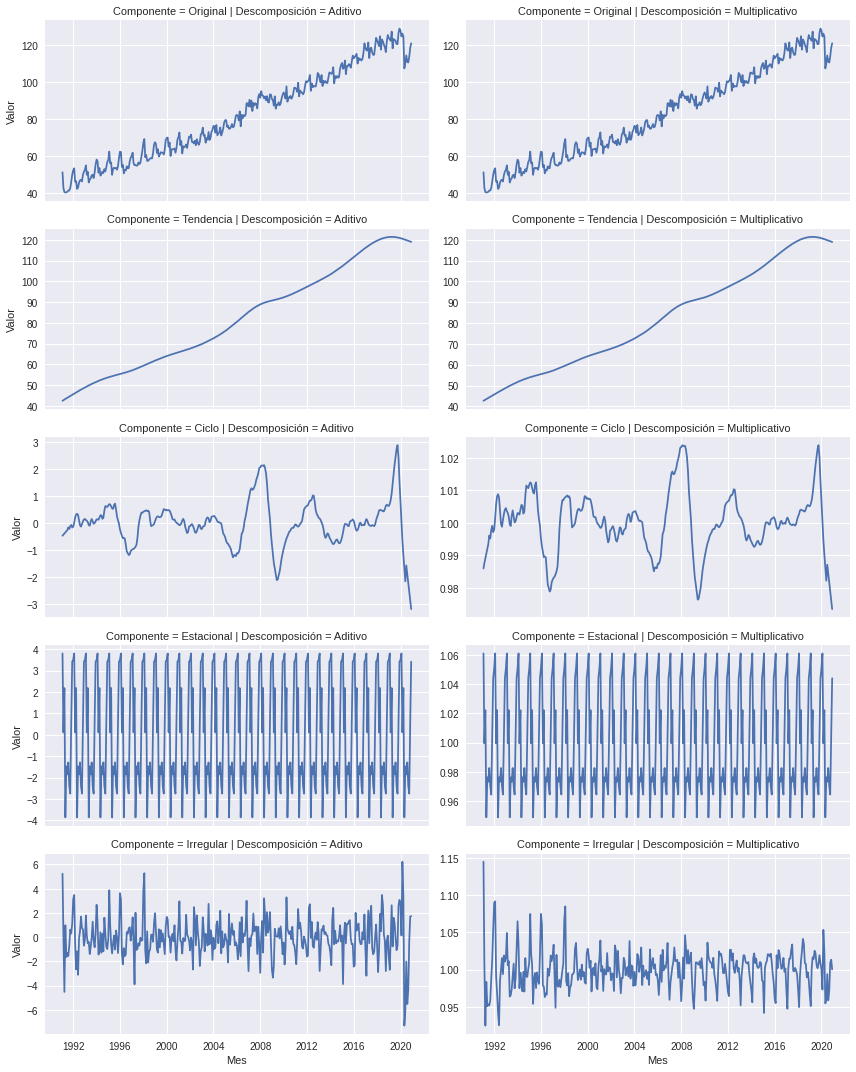

In [4]:
componentes = ['Original', 'Tendencia','Ciclo','Estacional','Irregular']

res = seasonal_decompose(imae, model='additive', period=12, extrapolate_trend='freq')
ciclo, tendencia = hpfilter(res.trend, lamb=14400)
additive = pd.concat([res.observed,tendencia, ciclo, res.seasonal, res.resid], axis=1)

res = seasonal_decompose(imae, model='multiplicative', period=12, extrapolate_trend='freq')
ciclo, tendencia = hpfilter(np.log(res.trend), lamb=14400)
multiplicative = pd.concat([res.observed, np.exp(tendencia), np.exp(ciclo), res.seasonal, res.resid], axis=1)

descomp = pd.concat([additive, multiplicative], keys=['Aditivo', 'Multiplicativo'])
descomp.columns = componentes
descomp = descomp.stack().reset_index()
descomp.columns = ['Descomposición','Mes','Componente', 'Valor']

g = sns.FacetGrid(descomp, row="Componente", col="Descomposición",
                  sharey=False, height=3.0, aspect=2.0)
g.map_dataframe(plt.plot, "Mes", "Valor");

Esta es una descomposición “ingenua”. Más adelante en el curso estudiaremos métodos más sofisticados.
</div>




## Enfoques clásico vs moderno de descomposición de series

Como los componentes **no son observables**, es necesario hacer supuestos acerca de su naturaleza para estudiar el proceso generador de la serie.


```{panels}
:header: bg-dark text-center text-white

Enfoque clásico
^^^
\begin{equation*}
Y_t = \underbrace{T_t + C_t + S_t}_{\text{determinísticos}}  + \underbrace{I_t}_{\text{estocástico}}
\end{equation*}
+++
Los componentes sistemáticos son funciones **determinísticas** del tiempo, el componente residual es estocástico pero **no contiene movimientos sistemáticos**.
---

Enfoque moderno
^^^
\begin{equation*}
Y_t = \underbrace{T_t + C_t + S_t + I_t}_{\text{estocásticos}}
\end{equation*}
+++
La “ley de movimiento” de la serie es vista como un **proceso estocástico**, y los datos de la serie como **una realización** del proceso generador de datos.
```


## 1930s -> Jan Tinbergen

En 1936, Tinbergen construyó el primer modelo econométrico: un modelo macroeconométrico de la economía holandesa, empezando así el desarrollo de la econometría aplicada.

En 1939, presentó su metodología para el análisis estadístico de teorías de ciclo económico, así como un modelo macroeconométrico de Estados Unidos.

Sus métodos fueron controversiales:

> “Nadie podría ser más franco, más meticuloso, más libre de prejuicios subjetivos o partidistas que el profesor Tinbergen. No hay nadie, por lo tanto, en lo que respecta a las cualidades humanas, a quien sería más seguro confiar con magia negra. Todavía no estoy convencido de que haya alguien en quien confiaría en la etapa actual o que esta marca de alquimia estadística está madura para convertirse en una rama de la ciencia. Pero Newton, Boyle y Locke jugaron con la alquimia. Así que déjenle continuar.”
>
> --- Keynes, 1940 (citado por Boumans2015)

## 1938 -> Herman Wold  
Wold sistematizó y generalizó el trabajo de Slutzky y Yule.

Demostró que para proceso covarianza-estacionario, puramente no-determinístico, existe una descomposición de la serie como combinación lineal de una serie de variables aleatorias no correlacionadas con media cero y varianza constante.

## 1949 -> Donald Cochrane y Guy H. Orcutt
Tinbergen utilizó los supuestos del modelo clásico de regresión lineal, sin prestar atención a la dependencia cronológica de los residuos.

En 1949 Cochrane y Orcutt notaron que esta práctica era problemática.

Demostraron que si los residuos de una regresión están positivamente correlacionados, entonces la varianza de los parámetros de regresión está subestimada y los estadísticos t y F sobrestimados.

El problema se podía resolver transformando los datos adecuadamente.

## 1950 -> James Durbin y Geoffrey S. Watson

En 1950/51 Durbin y Watson desarrollaron un test para identificar autocorrelación de primer orden en los residuos.

## 1970 -> George E.P. Box y Gwilym M. Jenkins
En 1970 Box y Jenkins publican un libro de texto de análisis de series de tiempo.

Introducen modelos univariados para series de tiempo, que usan sistemáticamente la información contenida en los valores de la serie.

Manera sencilla de producir pronósticos.

Hoy en día conocida como **metodología Box-Jenkins**.

```{figure} ./figures/box-jenkins.png
:scale: 45%

La metología Box-Jenkins
```

## 1975 -> Clive W.J. Granger y Paul Newbold
En 1975 Granger y Newbold mostraron que los pronósticos sencillos de métodos univariados a menudo eran mejores que los pronósticos basados en modelos econométricos grandes (cientos de ecuaciones).

Esto impulsó la enorme popularidad de la metodología Box-Jenkins.